# くじ引きの当たる確率をベイズ推論


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
import pandas as pd
import seaborn as sns

In [2]:
import pymc as pm
import arviz as az

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


常に確率が一定で、前回の結果が次回に一切影響しないくじ引きがある。このくじ引きを５回引いたところ、結果は
1. 当たり
2. はずれ
3. はずれ
4. 当たり
5. はずれ

だった。１回のくじ引きに当たる確率(p)を求めたい。
    


## ベルヌーイ分布 Ver

In [3]:
# Data（ベイズ推論で入力となる観測値） 準備
observations = np.array([1, 0, 0, 1, 0])  #観測値: [# 当たり, はずれ, はずれ, 当たり, はずれ]
print(observations)

[1 0 0 1 0]


In [4]:
# 確率Model 定義
model_uniform_bernoulli = pm.Model()  # インスタンス作成

# コンテキスト定義
with model_uniform_bernoulli:
    # 一様分布
    p = pm.Uniform('p', lower=0.0, upper=1.0)  # p: probability（確率）

    # ベルヌーイ分布
    # 1. 一様分布の確率変数 p をベルヌーイ分布のコンストラクタに対して確率値を示す引数として渡す
    # 2. 観測値 observations をベルヌーイ分布のコンストラクタに対して observed 引数として渡す
    X_obs = pm.Bernoulli('X_obs', p=p, observed=observations)

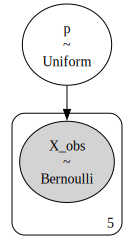

In [5]:
# 確率モデルの可視化
viz_model_uniform_bernoulli = pm.model_to_graphviz(model_uniform_bernoulli)
viz_model_uniform_bernoulli

- 今回の確率モデルで確率値`p` は値を１つしか持たない。
- 観測値 `X_obs` はベルヌーイ分布に従う確率変数で、観測値が５個存在する

上記は、共通の p を５つの観測値が共有する形になる。

In [6]:
# Sampling
with model_uniform_bernoulli:
    inferences_uniform_bernoulli = pm.sample(
        chains=3,  # 乱数系列の数
        tune=2000,  # 捨てる Smple数
        draws=2000,  # 取得する Sample数
        random_seed=42
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
NUTS: [p]


Sampling 3 chains for 2_000 tune and 2_000 draw iterations (6_000 + 6_000 draws total) took 21 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [7]:
# Sampling(Default)
with model_uniform_bernoulli:
    inferences_uniform_bernoulli_2 = pm.sample(random_seed=42)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 29 seconds.


Default では chains=4, tune=1000, draws=1000 となる。

### 結果分析
`[1 0 0 1 0]` という観測値が、ベルヌーイ分布を経由して、もともと一様分布だった**確率変数 p の事後分布がサンプル値の配列**　として得られた。
このサンプルの値に様々な処理を行い、事後分布の性質を確認する。

#### 実施事項
1. Sampling が正常にできていることの確認
2. 可視化による確率分布の確認
3. 統計分析による確率分布の確認

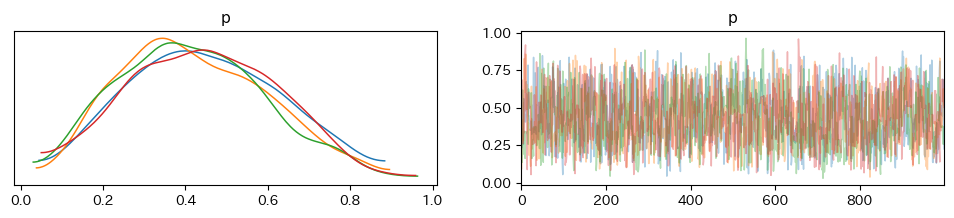

In [8]:
# Sampling が正常にできているか
az.plot_trace(inferences_uniform_bernoulli_2, compact=False)  # compact=False で,複数のサンプル直系列を色分け
plt.show()

#### 左のグラフ
- 横軸が分析対象の確率変数の値
- 縦軸はそれぞれの値に対する発生頻度

#### 右のグラフ
- 横軸が繰り返し回数
- 縦軸が分析対象の確率変数の値

縦軸の値が一定範囲を何度も行き来しているのが正しい挙動

４つのグラフの形がほぼ同じになっている為、うまくサンプリング出来たと解釈できる。

Text(0.5, 1.0, 'ベイズ推論\u3000Default')

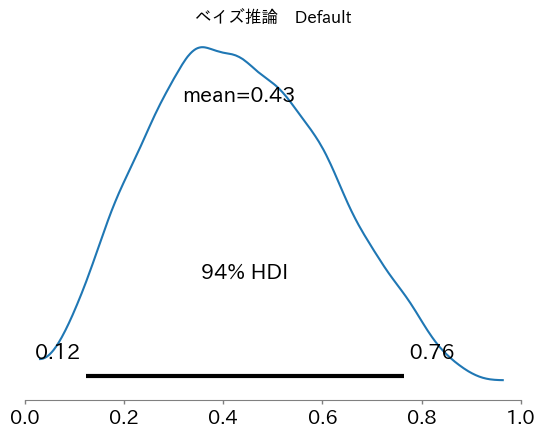

In [9]:
# 可視化による確率分布の確認
ax = az.plot_posterior(inferences_uniform_bernoulli_2,
                       # hdi_prob=0.65  HDI の閾値を設定できる
                       )
ax.set_xlim(0, 1)
ax.set_title('ベイズ推論　Default')

### 下のバー
分析対象の確率変数の 94% HDI の範囲を示している。

In [10]:
# 統計分析 & ベイズ推論が正しくできているか
summary_2 = az.summary(inferences_uniform_bernoulli_2)
summary_2

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
p,0.432,0.177,0.123,0.764,0.004,0.003,1662.0,2567.0,1.0


#### サンプリング結果への統計分析結果
- mean
- sd
- hdi_3%
- hdi_97%

#### ベイズ推論の正常性の指標
- mcse_mean: 0.01以下
- ess_bulk: 400以上
- r_hat: 1.01以下

> mcse: Monte Carlo standard error（モンテカルロ標準エラー）     
> ess: effective sample size（有効サンプルサイズ）


## 二項分布 Ver
今回の推定にあたって本質的な情報は「５回中２回当たり」という部分。
何度目に当たりが出たのかという情報はなくても、確率値`p`の予測はできると考え、**二項分布**を観測値の分布として設定して推論してみる。

In [11]:
# 確率モデル定義
model_uniform_binomial = pm.Model()

with model_uniform_binomial:
    p = pm.Uniform('p', lower=0.0, upper=1.0)  # 一様分布

    X_obs = pm.Binomial('X_obs', p=p, n=5, observed=2)
    # n= : 試行回数
    # observed= 当たりの回数

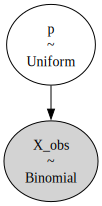

In [13]:
# 確率モデルの可視化
viz_model_uniform_binomial = pm.model_to_graphviz(model_uniform_binomial)
viz_model_uniform_binomial

二項分布になり、繰り返し構造がなくなり、よりシンプルな確率モデルになった。

In [14]:
# Sampling
with model_uniform_binomial:
    inferences_uniform_binomial = pm.sample(random_seed=42)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 22 seconds.


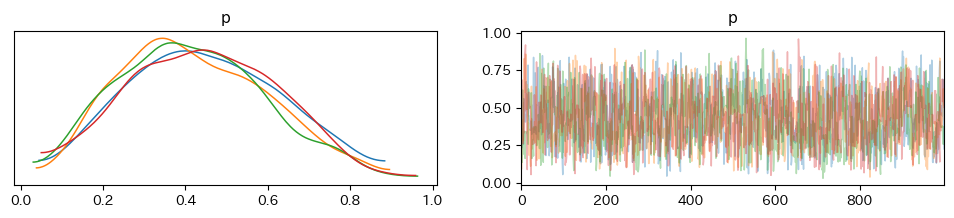

In [15]:
# Sampling の正常性
az.plot_trace(inferences_uniform_binomial, compact=False)
plt.show()

Text(0.5, 1.0, 'ベイズ推論\u3000二項分布')

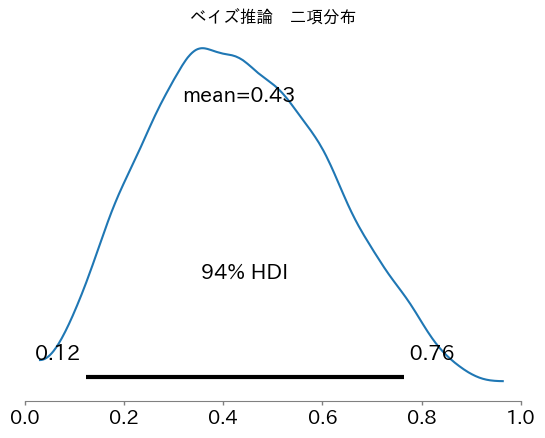

In [16]:
# 確率分布の可視化
ax = az.plot_posterior(inferences_uniform_binomial)
ax.set_xlim(0, 1)
ax.set_title('ベイズ推論　二項分布')

In [17]:
# 統計分析 & 推論基準値
summary_uniform_binomial = az.summary(inferences_uniform_binomial)
dict_reference = {
    'mcse_maen': 0.01,
    'ess_bulk': 400,
    'r_hat': 1.0,
}
print(summary_uniform_binomial['mcse_mean'] <= dict_reference['mcse_maen'])
print(summary_uniform_binomial['ess_bulk']  >= dict_reference['ess_bulk'])
print(summary_uniform_binomial['r_hat']     <= dict_reference['r_hat'])
summary_uniform_binomial

p    True
Name: mcse_mean, dtype: bool
p    True
Name: ess_bulk, dtype: bool
p    True
Name: r_hat, dtype: bool


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
p,0.432,0.177,0.123,0.764,0.004,0.003,1662.0,2567.0,1.0
